In [1]:
%matplotlib notebook

import tensorflow as tf
from tensorflow import keras

import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

import os
import subprocess
import nibabel as nib

import sys
sys.path.append("lib") # go to parent dir
import lib.imagenet_data_generator as imagenet_data_generator
import lib.models as models

In [2]:
n = 64
batch_size = 100
data_path = '/data/vision/polina/scratch/nmsingh/imagenet-data-preprocessed-'+str(n)

# Import training data
train_data_path = os.path.join(data_path,'train')
training_generator = imagenet_data_generator.DataSequence(train_data_path, batch_size, n)

# Import test data
test_data_path = os.path.join(data_path,'test')
test_generator = imagenet_data_generator.DataSequence(test_data_path, batch_size, n)

In [3]:
# Set up model
model = models.get_full_model(n)
model.compile(optimizer=keras.optimizers.RMSprop(lr=0.00002,rho=0.9),
        loss='mean_squared_error',
        metrics=[keras.metrics.mae])

# Load trained model weights
model.load_weights('training/IMAGENET-CLEAN-STANDARD-False-500epoch-64/cp-0500.ckpt')

In [4]:
(train_loss, train_mae) = model.evaluate_generator(training_generator)
(test_loss, test_mae) = model.evaluate_generator(test_generator)
print('Train loss: '+str(train_loss))
print('Train MAE: '+str(train_mae))
print('Test loss: '+str(test_loss))
print('Test MAE: '+str(test_mae))

Train loss: 0.26823239398588467
Train MAE: 0.036864095713534044
Test loss: 1.271712595940366
Test MAE: 0.08331888835821125


In [5]:
# Put single img_array into (batch_size,width,height,num_channels) format:
def batch_img(img_array):
    return np.expand_dims(np.expand_dims(img_array,0),-1)

# Generate k-space network input
def get_fft(img_array):
    img_fft = np.fft.fft2(img_array,axes=(1,2))
    img_fft_re = np.real(img_fft)
    img_fft_im = np.imag(img_fft)
    return np.concatenate([img_fft_re,img_fft_im],axis=3)

In [6]:
# Reconstruction comparison plotting utilities
def plot_single_comparison(true_recon,our_recon,img_domain=True):
    fig,axes = plt.subplots( 1,3, figsize=[12,4] )
    if(img_domain):
        suffix = 'Reconstruction'
    else:
        suffix = 'k-space'
    for i,iax in enumerate(axes.flatten()):
        if i==0:
            iax.imshow(true_recon,cmap='gray',vmin=0,vmax=1)
            iax.set_yticks([])
            iax.set_xticks([])
            iax.set_xlabel('True '+suffix)
        elif i==1:
            iax.imshow(our_recon,cmap='gray',vmin=0,vmax=1)
            iax.set_yticks([])
            iax.set_xticks([])
            iax.set_xlabel('AutoMAP '+suffix)
        elif i==2:
            iax.imshow(true_recon-our_recon,cmap='gray',vmin=0,vmax=1)
            iax.set_yticks([])
            iax.set_xticks([])
            iax.set_xlabel('Difference')
    fig.show()
    
def plot_2domain_comparison(true_recon,our_recon):
    plot_single_comparison(true_recon,our_recon,True)
    plot_single_comparison(get_fft(batch_img(true_recon))[0,:,:,0],get_fft(batch_img(our_recon))[0,:,:,0],False)
    
def plot_dataset_comparison(dataset,i):
    if(dataset=='Train'):
        generator = training_generator
    elif(dataset=='Test'):
        generator = test_generator
    else:
        raise ValueError('Misspecified dataset.')
        
    ex = generator[i]
    ex_in = ex[0]
    ex_out = model.predict(ex_in)

    true_img = ex[1][i,:,:,0]
    recon = ex_out[i,:,:,0]
    
    plot_2domain_comparison(true_img,recon)

<IPython.core.display.Javascript object>


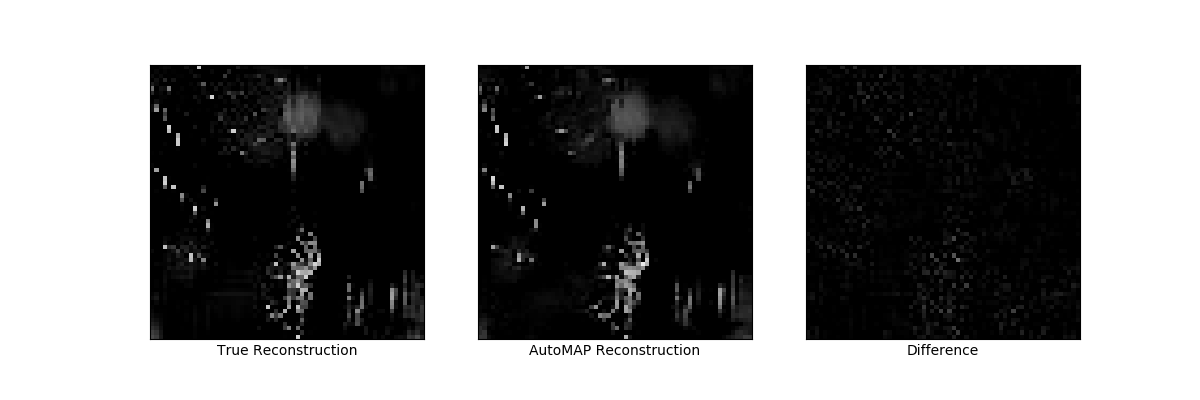

<IPython.core.display.Javascript object>


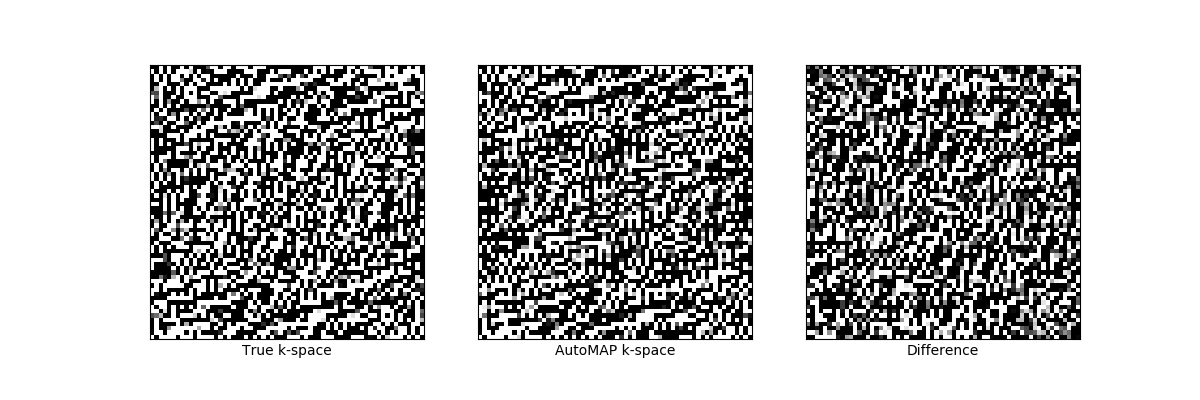

In [7]:
plot_dataset_comparison('Train',0)

<IPython.core.display.Javascript object>


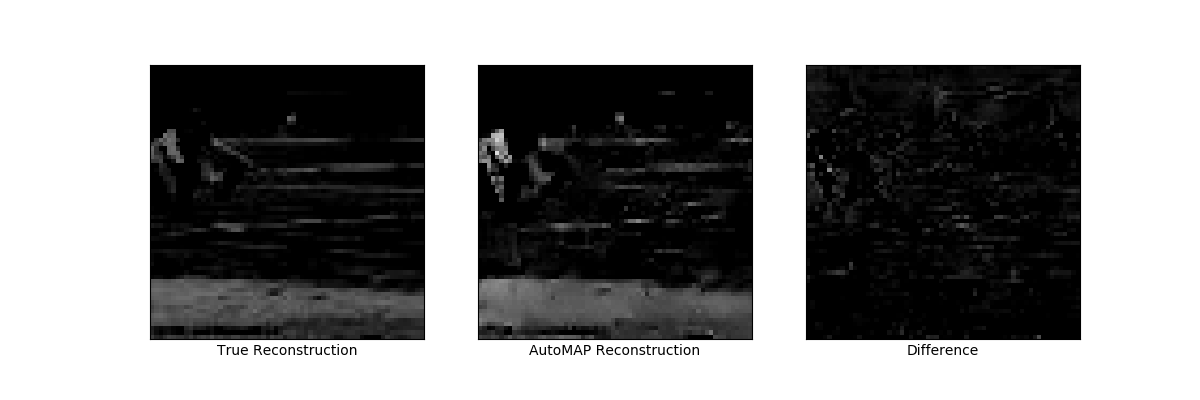

<IPython.core.display.Javascript object>


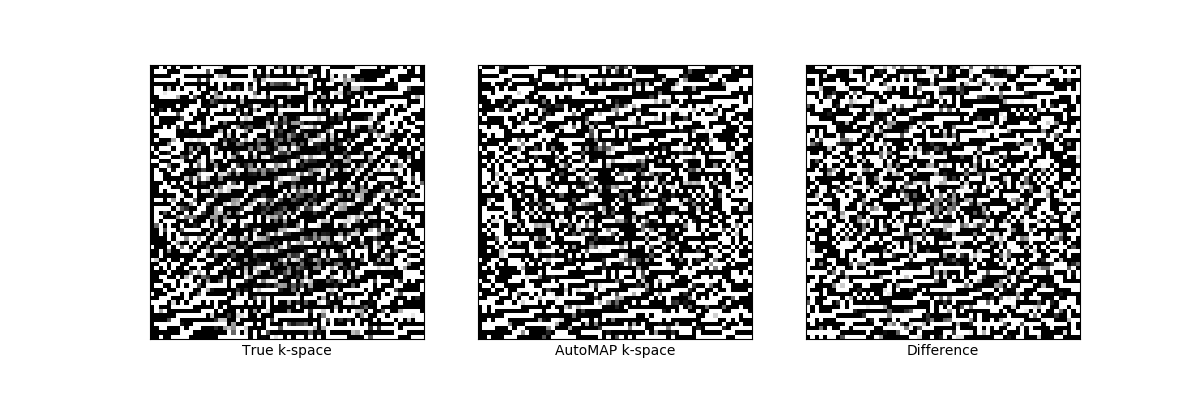

In [8]:
plot_dataset_comparison('Test',0)

<IPython.core.display.Javascript object>


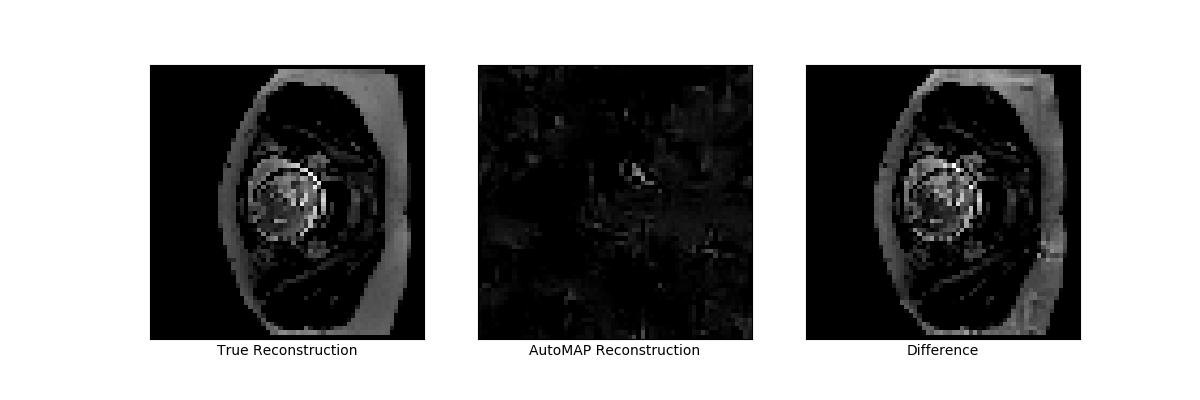

<IPython.core.display.Javascript object>


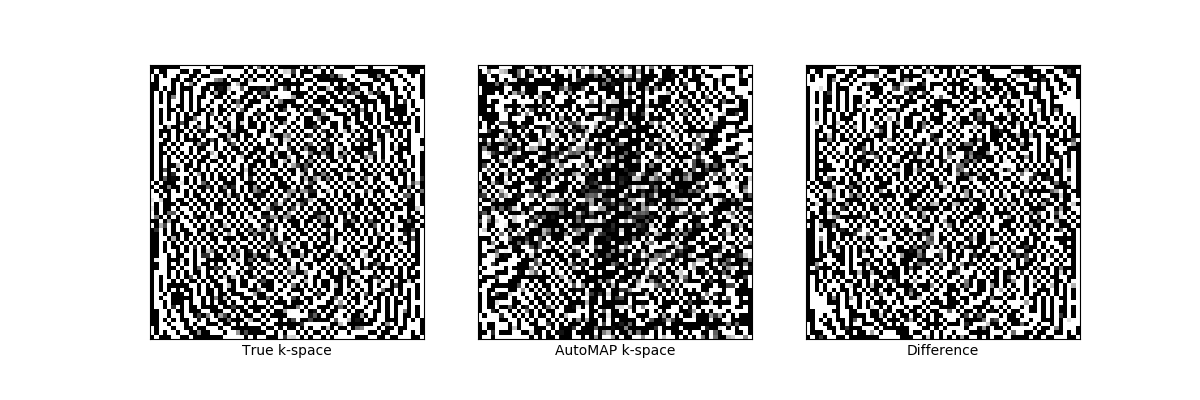

In [9]:
# Import fetal data
scannumber = 'MAP-C401-031615'
filename = 'PLACENTASTUDY_03162015_1.MR.0003_0000'
data_path = os.path.join('/data/vision/polina/projects/fetal_data/data/haste/Singleton-Control',scannumber,filename+'.nii.gz')
seg_path = os.path.join('/data/vision/polina/projects/fetal_data/data/haste/Singleton-Control-Segmentations',scannumber,filename+'-Segmentation-label.nii.gz')
img = nib.load(data_path).get_data()
sl = img[:,:,int(img.shape[2]/2)]
sl_downsample = np.array(Image.fromarray(sl).resize((n,n)))*255.0/1493.05
sl_downsample = sl_downsample-sl_downsample.mean()
sl_downsample = sl_downsample/255.
sl_k = get_fft(batch_img(sl_downsample))

# Fetal comparisons
sl_pred = model.predict(sl_k)[0,:,:,0]
plot_2domain_comparison(sl_downsample,sl_pred)